# **Practica final modulo deep learning**

El objetivo final de esta práctica es el de construir un programa que tenga como entrada una imagen, y de como salida una frase que la describa

El dataset inicial de trabajo es el Flickr8K

##Planteamiento

La forma inicialmente planteada no me acaba de convencer, me parece que pretender que la red construya una frase coherente en base a a las palabras que ya ha generado, no puede dar muy buen resultado.

Mi planteamiento para realizarlo de otra manera, se basa en simplificar el problema, para poder obtener unos resultados mas coherentes aunque tiene otros problemas. La idea se basa un poco en el concepto de "atención", aunque por simplicidad esta implementado de otra manera. Basicamente lo que se pretende es, dada la descripción de la fotografía, extraer las características mas relevantes de esta, es decir, las palabras que mas peso tienen y que mejor la describen para entrenar la red solo con ellas.

En una versión muy simplificada de este concepto, lo que realizo es extraer de la frase el objeto principal(nombre) y la acción(verbo). Posteriormente, la red se estructura de la sigiente manera:

*   Una primera red extrae las características de la imagen
*   Una segunda capa, con las características de la imagen predice el objeto principal que hay en ella
*   Una tercera capa, con las características de la imagen y el objeto principal que se ha detectado, predice la acción.
*   La salida de la red son 2 palabras, el objeto detectado y la acción

Evidentemente es versión simplificada tiene una serie de contras

* No se genera una frase en lenguaje natural, si no un mensaje en "indio", como por ejemplo "niño comer"
* No todas las descripciones tiene porque tener un objeto y una acción
* Pueden existir varios objetos y acciones en la misma imagen.

Una vez explicado el concepto, comienzo con la implementación, donde explico como he resueto diferentes problemas

In [0]:
#Descargamos el dataset y lo descomprimimos
!wget http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_text.zip
!unzip -o Flickr8k_text.zip
!pip install -U spacy
!python -m spacy download en
!rm -rf Flickr8k_Dataset*
!rm -rf Flicker8k_Dataset
!wget http://nlp.cs.illinois.edu/HockenmaierGroup/Framing_Image_Description/Flickr8k_Dataset.zip
!unzip -o Flickr8k_Dataset.zip
!pip install tqdm
!pip install networkx==1.11 # para instala hyperopt correctamente, si no, da errores
!pip install hyperopt

Carga de las descripciones del dataset

In [2]:
# Carga del documento
def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text
 
# extract descriptions for images
def load_descriptions(doc):
	mapping = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		if len(line) < 2:
			continue
		image_id, image_desc = tokens[0], tokens[1:]
		image_id = image_id.split('.')[0]
		image_desc = ' '.join(image_desc)
		if image_id not in mapping:
			mapping[image_id] = image_desc
	return mapping

descriptions = load_descriptions(load_doc('Flickr8k.token.txt'))
print('Cargadas %d descripciones' % len(descriptions))


Cargadas 8092 descripciones


## Tratamiento de las descripciones

Para el tratamiento del texto voy a usar spaCy, una librería para el tratamiento de NLP basada en redes neuronales.

Tratamos el texto para extraer de la frase el verbo y el nombre, en una primera aproximación si hay mas de un nombre y un verbo los coge aleatoriamente, y si no encuantra ninguno no trato ese caso.


In [0]:
import spacy
nlp = spacy.load('en')

desc_processed = {}
verbs = []
nouns = []
for key, desc in descriptions.items():
  text = nlp(desc)
  noun = 'NA'
  verb = 'NA'
  for token in text:
    if token.pos_ == 'NOUN':
      noun = token.lemma_
    if token.pos_ == 'VERB':
      verb = token.lemma_
  desc_processed[key]= (noun,verb)
  nouns.append(noun)
  verbs.append(verb)

nlp=''


Contamos el número de verbos diferentes que tenemos y el número de nombres

In [3]:
num_nouns = len(set(nouns))
num_verbs = len(set(verbs))

print('Numero de nombres:' + str(num_nouns))
print('Numero de verbos:' + str(num_verbs))

Numero de nombres:1226
Numero de verbos:622


Guardo las descripciones para no perder este procesamiento

In [4]:
# save descriptions to file, one per line
def save_doc(descriptions, filename):
	lines = list()
	for key, desc in descriptions.items():
		lines.append(key + '#' + desc[0] + ',' + desc[1])
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

# save descriptions
save_doc(desc_processed, 'descriptions_processed.txt')

##Procesamiento de las imágenes

Lo que vamos a hacer es usar la arquitectura InceptionV3, preentrenada con el dataset 'imagenet'.  vamos a realizar transfer learning sobre esta arquitectura, por lo que cargamos el modelo sin las ultimas capas (top), de esta forma podemos usar la extracción de características,y añadirle nuevas capas para la predicción que quereos realizar. Las capas de extraccion de características no las vamos a entrenar, por lo que se congelan, solo para entrenar las nuevas capas.

In [5]:
import numpy as np
from os import listdir
from pickle import load, dump
from tqdm import tqdm
from numpy import array
from numpy import argmax
from pandas import DataFrame
from nltk.translate.bleu_score import corpus_bleu
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.applications import InceptionV3
from keras.applications import VGG16
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.layers import Input, Dense, Flatten, LSTM, RepeatVector, TimeDistributed, Embedding, Dropout
from keras.layers.merge import concatenate
from keras.layers.pooling import GlobalMaxPooling2D
from keras.optimizers import Adam
import pickle

Using TensorFlow backend.


In [6]:
in_layer = Input(shape=(299, 299, 3))
base_model = InceptionV3(include_top=True, input_tensor=in_layer, weights='imagenet')
#base_model.summary()

La capa de salida en este caso va a predecir el nombre que describe la fotografia, por lo qye tendrá tantas neuronas de salida como nombre diferentes tenemos

Solo cambiamos la última capa de prediccion de la incepcionV3 y es la unica que entrenamos, el resto se congelan

In [8]:
params_layer_nouns={'optimizer_lr':0.001 }



# congelamos todas las capas de nuestro base_model para que no se entrenen
# queremos que nuestro feature extractor siga igual que antes => transfer learning
for layer in base_model.layers: 
  layer.trainable = False
  #print('Capa ' + layer.name + ' congelada.')

# cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
last = base_model.layers[-2].output
x = Dense(num_nouns+1, activation='softmax', name='predictions')(last)
model = Model(base_model.input, x)

base_model=''

# compilamos el modelo
model.compile(optimizer=Adam(lr=params_layer_nouns['optimizer_lr']), loss='categorical_crossentropy', metrics=['accuracy'])

# vemos la estructura del modelo
#model.summary()

Cargamos las imágenes, les ponemos el formato que necesita la red y las normalizamos

Solo utilizamos 2000 imagenes para evitar tener problemas de memoria con el colab

In [9]:
directory = 'Flicker8k_Dataset'
limit=2000

files_in_directory = listdir(directory)
n_images = len(files_in_directory)
X = []
Y_Noun = []
Y_Verb = []

for i, name in tqdm(enumerate(files_in_directory)):
    filename = directory + '/' + name
    image_id = name.split('.')[0]
    image = load_img(filename, target_size=(299, 299))
    image = img_to_array(image) / 255  
    #image = np.expand_dims(image, axis=0)
    X.append(image)
    (noun,verb) = desc_processed[image_id]
    Y_Noun.append(noun)
    Y_Verb.append(verb)
    if(i > limit):
      break;
X = np.array(X)
    

1997it [00:12, 160.78it/s]

Preparamos el texto para poder introducirlo a la red

In [10]:
def create_tokenizer(words):
  a = set()
  for word in words:
    a.add(word) 
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(a)
  return tokenizer

tokenizer_noun = create_tokenizer(nouns)
tokenizer_verb = create_tokenizer(verbs)

In [11]:
Y_Noun = tokenizer_noun.texts_to_matrix(Y_Noun)
Y_Verb = tokenizer_verb.texts_to_matrix(Y_Verb)

Dividimos los datos en train y test

In [12]:
from sklearn.model_selection import train_test_split
seed = 7
X_train, X_test, y_Noun_train, y_Noun_test, y_Verb_train, y_Verb_test = train_test_split(X, Y_Noun,Y_Verb, test_size=0.33, random_state=seed)

X=''

Entrenamos el nuevo modelo, en este caso solo se entrenan las últimas capas ya que las otras estan congeladas

In [0]:

epochs = 15
batch_size = 128

model.fit(X_train,y_Noun_train, epochs=epochs,batch_size=batch_size)

El accuracy conseguido con un batch de 128 y 15 epocas es bueno.

1341/1341 [==============================] - 14s 11ms/step - loss: 0.6241 - acc: 0.9575
<keras.callbacks.History at 0x7f52731eb0f0>

A continuación pasamos a crear la capa que va a reconocer los verbos en función de las imágenes. Congeamos todas las capas ya entrenadas salvo las nuevas que vamos a añadir para entrenar con los verbos

Conectamos nuestra nueva capa de prediciones

In [14]:
params_layer_verbs={'optimizer_lr':0.001 }

# congelamos todas las capas de nuestro base_model para que no se entrenen
# queremos que nuestro feature extractor siga igual que antes => transfer learning
base_model = model

for layer in base_model.layers: 
  layer.trainable = False
  #print('Capa ' + layer.name + ' congelada.')

# cogemos la última capa del model y le añadimos nuestro clasificador (top_model)
imgspredict_l = base_model.layers[-2].output
nouns_predict = base_model.layers[-1].output

merge_one = concatenate([imgspredict_l, nouns_predict])

verbs_predict = Dense(num_verbs+1, activation='softmax', name='predictionsverb')(merge_one)

model = Model(base_model.input, [nouns_predict, verbs_predict])

# compilamos el modelo
model.compile(optimizer=Adam(lr=params_layer_verbs['optimizer_lr']), loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
epochs = 15
batch_size = 128

model.fit(X_train,[y_Noun_train, y_Verb_train], epochs=epochs,batch_size=batch_size)

El accuracy conseguido con un batch de 128 y 15 epocas es bueno.

1341 [==============================] - 14s 11ms/step - loss: 1.6836 - predictions_loss: 0.5532 - predictionsverb_loss: 1.1304 - predictions_acc: 0.9679 - predictionsverb_acc: 0.8233
<keras.callbacks.History at 0x7f52732c92e8>

A continuación pasamos a evaliuar en test

In [16]:
acc = model.evaluate(X_test,[y_Noun_test, y_Verb_test], batch_size=batch_size)

661/661 [==============================] - 11s 17ms/step


In [17]:
print('labels:', model.metrics_names)
print('Result:', acc)

labels: ['loss', 'predictions_loss', 'predictionsverb_loss', 'predictions_acc', 'predictionsverb_acc']
Result: [12.494921368297398, 7.058270989676286, 5.436650193945903, 0.10892586992227905, 0.11195158870515953]


labels: ['loss', 'predictions_loss', 'predictionsverb_loss', 'predictions_acc', 'predictionsverb_acc']

Result: [12.494921368297398, 7.058270989676286, 5.436650193945903, 0.10892586992227905, 0.11195158870515953]


Los resultados en test no son nada buenos, el modelo se ajusta bastante bien a los datos de entrenamiento, pero no generaliza nada bien a los datos de test. El principal problema creo que se encuentra en los pcos datos con los que estamos realizando el entrenamiento de la red que no han posible que generalice adecuadamente. Se podrían usar técnicas de regularización si se tratara de overfitting, pero no creo que sea el caso.

Para aumentar el nímerod e muestras, podríamos aumentar el tamaño del dataset, o podrámos utilizar técnicas de data augmentation, pero no lo voy a realizar porque la infraestructura del colab no da para mas computo.

A continiación pasamos a visualizar alun ejemplo real de como se comporta.

Predicted: bike rid
Real: bike motorize


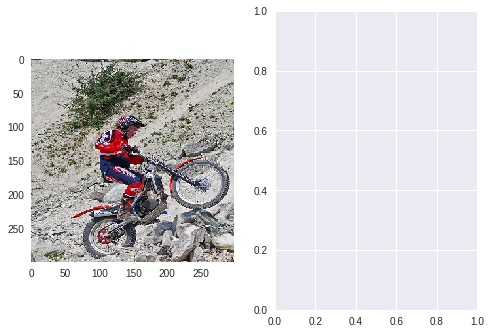

In [22]:
index1=35

pred_1 = model.predict(np.expand_dims(X_train[index1], axis=0), verbose=0)

from matplotlib import pyplot as plt
#argmax(pred_1)
noun_pred = argmax(pred_1[0])
verb_pred = argmax(pred_1[1])

def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

print('Predicted:',word_for_id(noun_pred, tokenizer_noun), word_for_id(verb_pred, tokenizer_verb))
print('Real:',word_for_id(argmax(y_Noun_train[index1]), tokenizer_noun), word_for_id(argmax(y_Verb_train[index1]), tokenizer_verb))

f, ax = plt.subplots(1, 2)
ax[0].imshow(X_train[index1])
ax[0].grid(False)